# Influence Maximization at Scale (with Fairness)

## Resources
This notebook is based off a few resources:

**Data:**

[Data](https://drive.google.com/file/d/1AFuShgAdyoqodqR1oFlCRp7okEYDdeLt/view) - 13 GB

**Papers:**
1. Primary: https://arxiv.org/pdf/2306.01587.pdf
2. Secondary: https://arxiv.org/abs/1904.08804

**Code:**
1. Primary: https://github.com/yu-ting-feng/fair_at_scale
2. Secondary: https://github.com/geopanag/IMINFECTOR/tree/master


## Pre-Requisites and Background Context
1. This notebook must run in a Google Collab environment with [Pro subscription](https://colab.research.google.com/signup) .
2. The data must be stored in a google drive account on which the user has full permissions to read / write. This notebook will attempt to connect to user's google drive and write to it.
3. The storage requirements within Google drive must be > 50 GB of write-able space.
4. The memory requirements of this notebook are high, the pro subscription currently gives access to 50 GB worth of memory, which is a good starting point. Realistically, you need over 150 GB of RAM to run this notebook for the full graph

## Google Drive Setup

Create a directory called `FairInfluenceMaximization` under which there are 2 sub-directories:
1. data
2. code

The data directory should contain the Data.zip (20 GB data file). Your setup should look identical to the below images


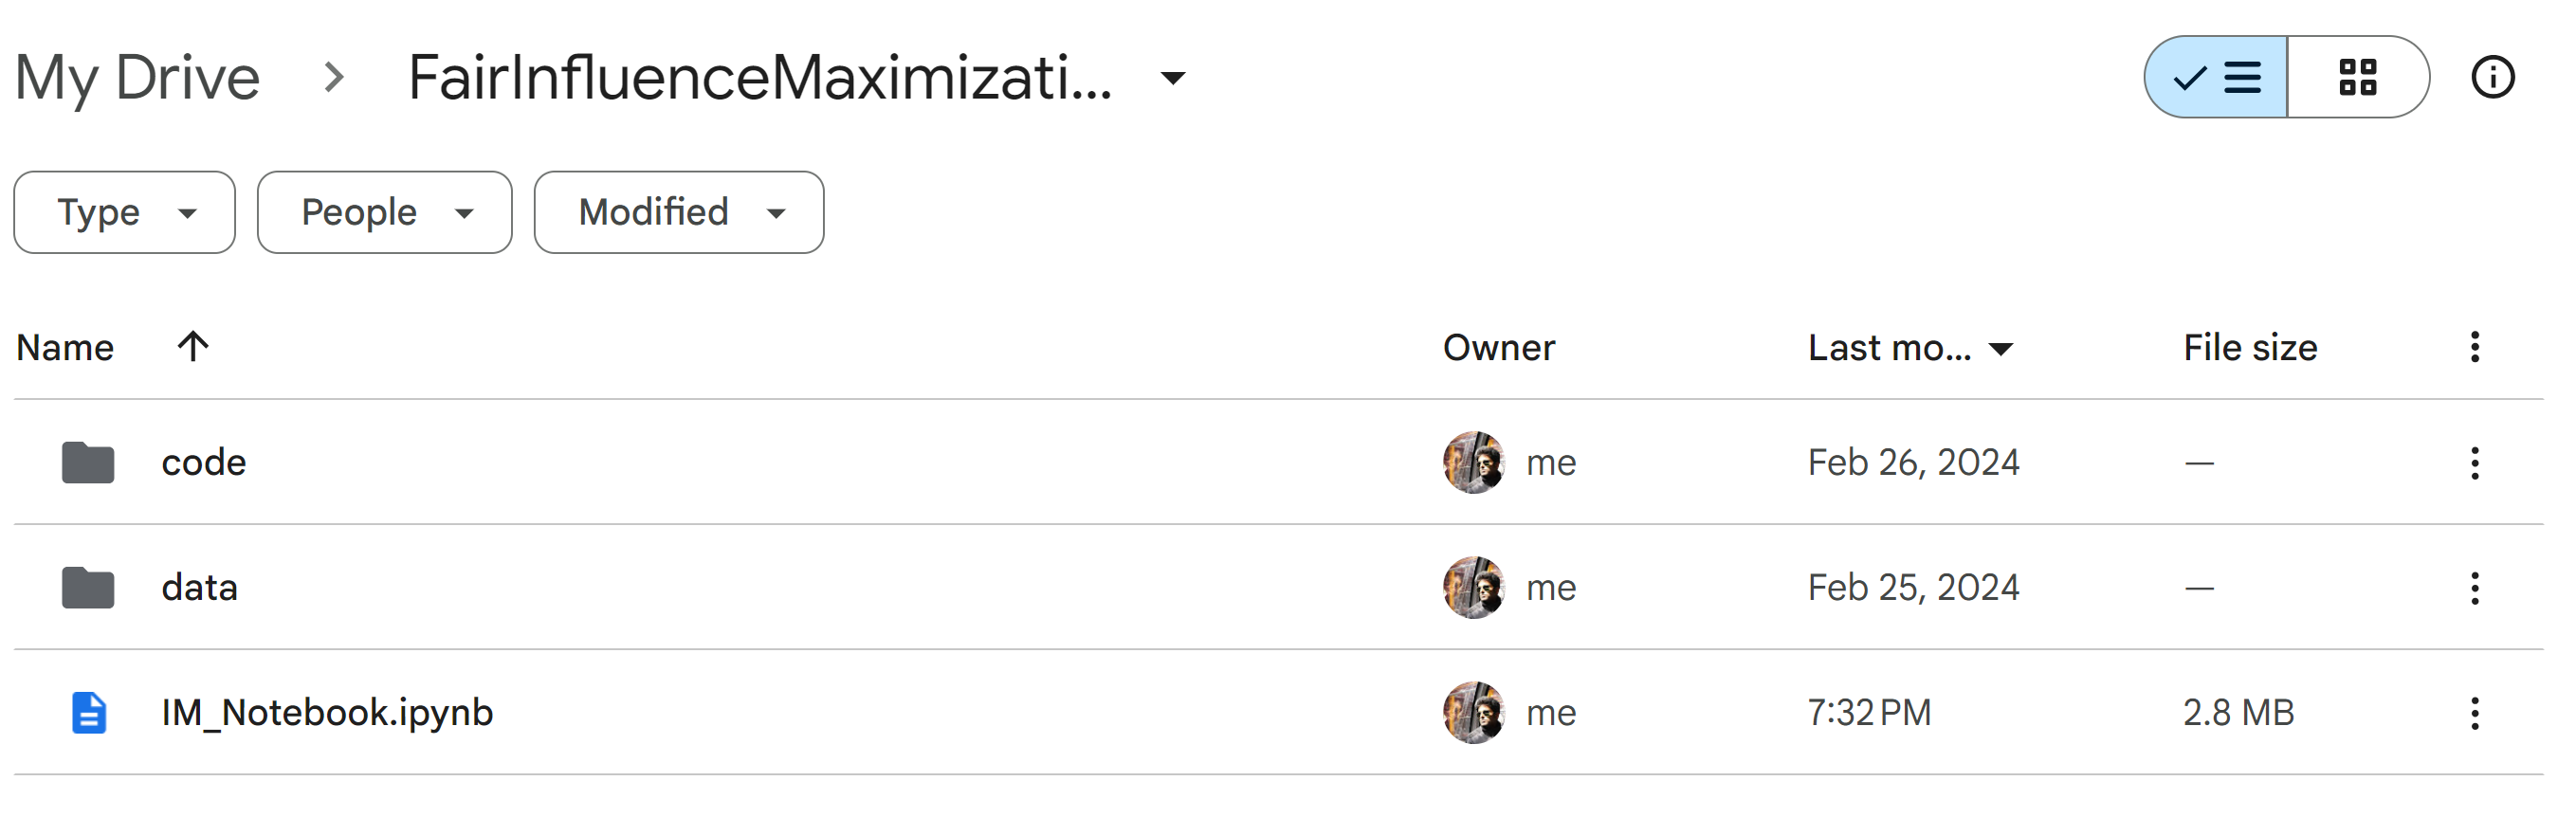

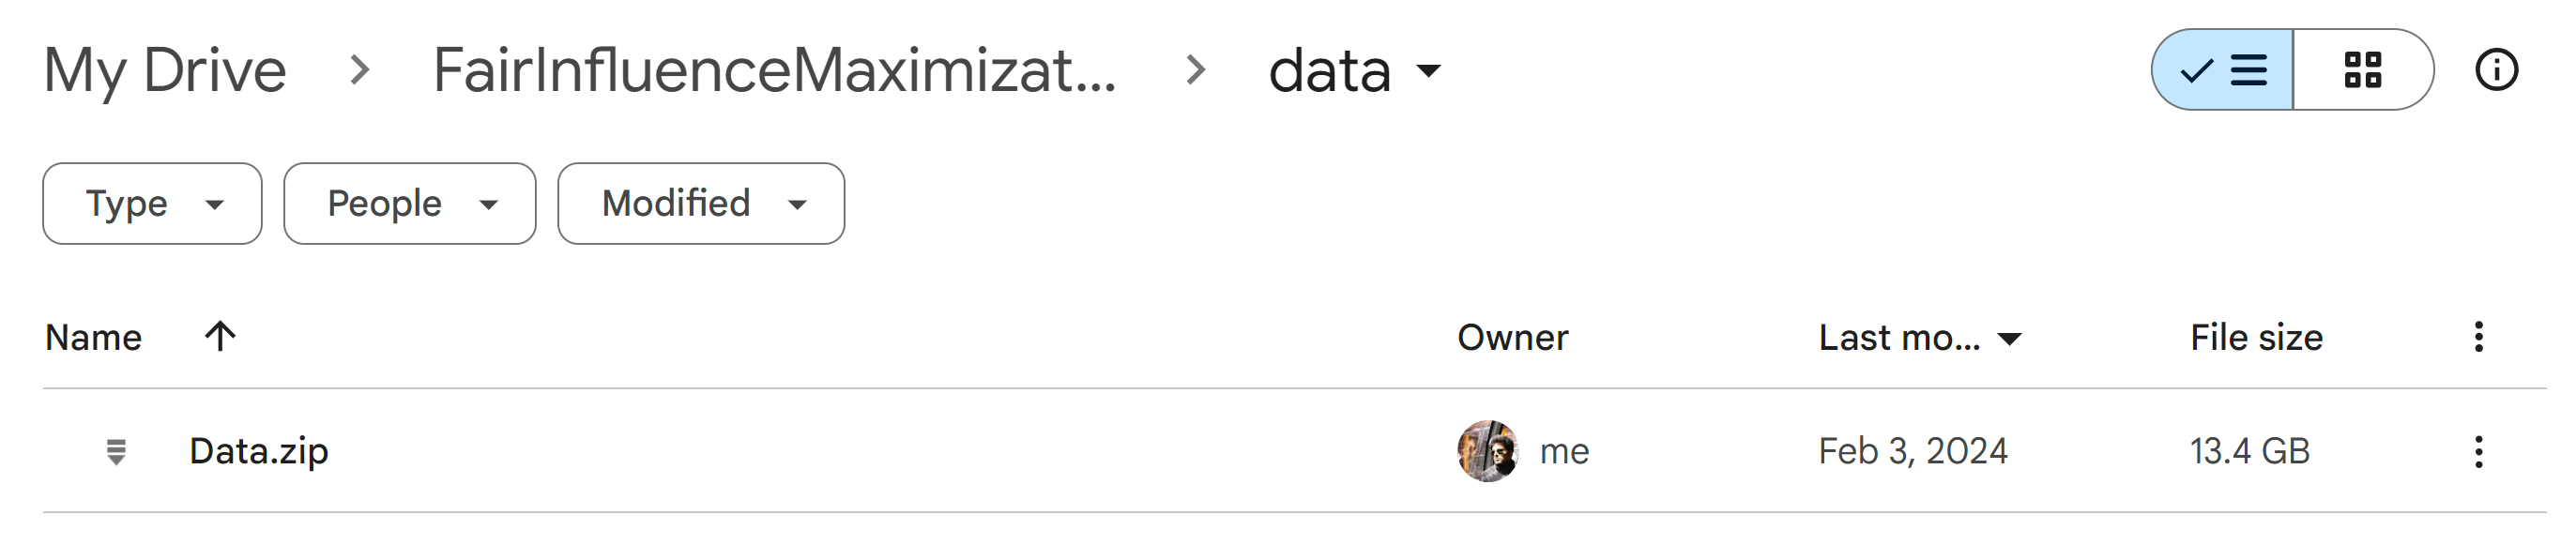

In [1]:
# Ensure you have enough RAM
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print(f"Your runtime has {ram_gb} gigabytes of available RAM")

if ram_gb < 20:
  print("Not using a high-RAM runtime")
else:
  print("You are using a high-RAM runtime!")

Your runtime has 67.439476736 gigabytes of available RAM
You are using a high-RAM runtime!


In [2]:
# Justin's version (justinryanwong@berkeley.edu)
# If false, allows using this publicly avaiable container storage bucket
# https://console.cloud.google.com/storage/browser/fair-influence-maximization-mounted?hl=en&project=d4w3-369005&pageState=(%22StorageObjectListTable%22:(%22f%22:%22%255B%255D%22))&prefix=&forceOnObjectsSortingFiltering=false
USE_GDRIVE = False
if USE_GDRIVE:
  !pip install google-colab
  from google.colab import drive
  # allow perms
  drive.mount('/gdrive')
else:
  # Justin's version (justinryanwong@berkeley.edu)
  from google.colab import auth
  auth.authenticate_user()
  import os

  # Install gcsfuse: https://cloud.google.com/storage/docs/gcsfuse-install
  # !uname -a # uname gets the system environment info.
  # !export GCSFUSE_REPO=gcsfuse-`lsb_release -c -s` in colab enterprise
  !lsb_release -c -s
  os.environ["GCSFUSE_REPO"] = "gcsfuse-jammy" # jammy is the output of "!lsb_release -c -s"
  !echo "deb https://packages.cloud.google.com/apt $GCSFUSE_REPO main" | sudo tee /etc/apt/sources.list.d/gcsfuse.list
  !curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -
  !apt-get update -y
  !apt-get install -y fuse gcsfuse

  # verify gcsfuse is installed properly.
  !gcsfuse --version

  # Mounting GCS
  import os
  # Since this can't directly connect to gdrive, create this as mount path. This makes it compatible with Michael's gdrive
  os.makedirs('/gdrive/MyDrive/FairInfluenceMaximization', exist_ok=True)
  !gcsfuse --implicit-dirs fair-influence-maximization-mounted /gdrive/MyDrive/FairInfluenceMaximization


jammy
deb https://packages.cloud.google.com/apt gcsfuse-jammy main
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2659  100  2659    0     0  16863      0 --:--:-- --:--:-- --:--:-- 16829
OK
Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://packages.cloud.google.com/apt gcsfuse-jammy InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:10 https://ppa.lau

### File Config Setup

In [22]:
# DO NOT CHANGE THIS
PARENT_PATH = "/gdrive/MyDrive/FairInfluenceMaximization/"
DATA_PATH = PARENT_PATH + "data/"
DATA_PATH_UNZIPPED = DATA_PATH + "Data/"
CODE_PATH = PARENT_PATH + "code/"
DATA_INIT_PATH = DATA_PATH_UNZIPPED + "Weibo/Init_Data/"
DATA_FPS_PATH = DATA_PATH_UNZIPPED + "Weibo/FPS/"
DATA_FAC_PATH = DATA_PATH_UNZIPPED + "Weibo/FAC/"
RUN_ID = "Full-attempt_2024-03-12"
DATA_OUTPUT_PATH = DATA_PATH_UNZIPPED + f"Weibo/Output_{RUN_ID}/"
DATA_EMBEDDINGS_PATH = DATA_OUTPUT_PATH + "Embeddings/"
DATA_SEEDS_PATH = DATA_OUTPUT_PATH + "Seeds/"
DATA_SEEDS_SPREADING_PATH = DATA_OUTPUT_PATH + "Spreading/"
DATA_ZIP = "Data.zip"
OPT_DATA = "/opt/data/"

### Data Copy and Unzip

In [11]:
!mkdir -p {DATA_PATH}
!mkdir -p {CODE_PATH}

Now copy the Data.zip file into `/gdrive/MyDrive/FairInfluenceMaximization/data/`

In [12]:
contents = !ls {DATA_PATH}
contents = str(contents)
contents

"['Data  Data.zip\\t__MACOSX']"

In [13]:
# if Data.zip has been unzipped, then it would occur twice
# flimsy logic, but works for now
count_data = contents.count("Data")

In [ ]:
%%time
import os

# At least Data.zip should be present
if DATA_ZIP not in contents:
  raise Exception(f"Please copy over {DATA_ZIP} into the folder: {DATA_ZIP}")

if os.path.exists(DATA_PATH) and count_data == 1 and DATA_ZIP in contents:
  data_zip_path = DATA_PATH + DATA_ZIP
  print(f"Unzipping data to path: {data_zip_path}, should take about 10 minutes")
  !unzip {data_zip_path} -d {DATA_PATH}

Unzipping data to path: /gdrive/MyDrive/FairInfluenceMaximization/data/Data.zip, should take about 10 minutes
Archive:  /gdrive/MyDrive/FairInfluenceMaximization/data/Data.zip
   creating: /gdrive/MyDrive/FairInfluenceMaximization/data/Data/
  inflating: /gdrive/MyDrive/FairInfluenceMaximization/data/Data/time_log.txt  
  inflating: /gdrive/MyDrive/FairInfluenceMaximization/data/__MACOSX/Data/._time_log.txt  
  inflating: /gdrive/MyDrive/FairInfluenceMaximization/data/Data/.DS_Store  
  inflating: /gdrive/MyDrive/FairInfluenceMaximization/data/__MACOSX/Data/._.DS_Store  
   creating: /gdrive/MyDrive/FairInfluenceMaximization/data/Data/Weibo/
  inflating: /gdrive/MyDrive/FairInfluenceMaximization/data/Data/Weibo/.DS_Store  
  inflating: /gdrive/MyDrive/FairInfluenceMaximization/data/__MACOSX/Data/Weibo/._.DS_Store  
   creating: /gdrive/MyDrive/FairInfluenceMaximization/data/Data/Weibo/FAC/
  inflating: /gdrive/MyDrive/FairInfluenceMaximization/data/Data/Weibo/weibo_incr_dic.json  
  in

In [14]:
# create these after unzipping, else zipping won't work
!mkdir -p {DATA_OUTPUT_PATH}
!mkdir -p {DATA_EMBEDDINGS_PATH}
!mkdir -p {DATA_SEEDS_PATH}
!mkdir -p {DATA_SEEDS_SPREADING_PATH}

In [15]:
# assert that you have unzipped the folder
contents = !ls {DATA_PATH}
contents = str(contents)
count_data = contents.count("Data")
assert(count_data > 1)

In [ ]:
# copy locally all large files as reading from disk over mount is very slow
!mkdir {OPT_DATA}
!rm -rf {OPT_DATA}*
!ls {OPT_DATA}*

weibo_network_txt_path = DATA_INIT_PATH + "weibo_network.txt"
!rsync -avz --progress {weibo_network_txt_path} {OPT_DATA}

# ensure the copy was successful
!diff -q {weibo_network_txt_path} {OPT_DATA}

ls: cannot access '/opt/data/*': No such file or directory
sending incremental file list
weibo_network.txt
  3,739,600,920 100%   79.19MB/s    0:00:45 (xfr#1, to-chk=0/1)

sent 925,705,096 bytes  received 35 bytes  20,345,167.71 bytes/sec
total size is 3,739,600,920  speedup is 4.04


In [16]:
# confirm file locations of critical data files
def check_critical_file_location(fName, verbose=False, parent_path=None):
  if not parent_path:
    parent_path = DATA_PATH

  x = !find {parent_path} -type f -name {fName}
  if verbose:
    print(x)
  assert(len(x) >=1)

check_critical_file_location("train_cascades.txt")
check_critical_file_location("test_cascades.txt")
check_critical_file_location("active_users.txt")
check_critical_file_location("weibo_network.txt")
check_critical_file_location("uidlist.txt")
check_critical_file_location("user_profile1.txt")
check_critical_file_location("user_profile2.txt")
check_critical_file_location("weibo_network.txt", parent_path=OPT_DATA)

### Repo Setup

In [17]:
# clone repo (contains both the IMINFECTOR repo and the fairness at scale repo)
%cd {CODE_PATH}
# !git clone https://github.com/geopanag/IMINFECTOR.git
# !git clone https://github.com/goldenretriever-5423/fair_at_scale.git
# For some reason, cloning forked repos is not able to find the remote repo
# !git clone https://github.com/abhisha1991/fair_at_scale.git

/gdrive/MyDrive/FairInfluenceMaximization/code


In [18]:
# assign repo paths
REPO_FAIR_IM_PATH = CODE_PATH + "fair_at_scale/"
REPO_IMINFECTOR_PATH = CODE_PATH + "fair_at_scale/IMINFECTOR/"

In [8]:
# install libraries
%pip install networkx pandas numpy tensorflow igraph pyunpack patool

In [9]:
# import infector libraries
# abhisha: TODO Delete: most of this is not really needed
# repo_im_fairness_models_path = REPO_FAIR_IM_PATH + "models/"
# %cd {repo_im_fairness_models_path}

import sys
%set_env PYTHONPATH=/env/python:{REPO_IMINFECTOR_PATH}
sys.path.append(REPO_IMINFECTOR_PATH)

import evaluation
import extract_feats_and_trainset
import iminfector
import infector
import preprocess_for_imm
import preprocessing
import rank_nodes
# assumes pwd: /gdrive/MyDrive/FairInfluenceMaximization/code
from fair_at_scale.models import fair_iminfector
# import fair_iminfector

# imports
import json
import os
import time
from datetime import datetime
from typing import Dict
import igraph as ig
import numpy as np
from collections import defaultdict
import math
import argparse
import pandas as pd

env: PYTHONPATH=/env/python:/gdrive/MyDrive/FairInfluenceMaximization/code/fair_at_scale/IMINFECTOR/


## Project Setup

### IM App Config Setup

In [23]:
# define main control parameters
INPUT_FN = "weibo"
ATTRIBUTE = "gender"
SAMPLING_PERC = 120
LEARNING_RATE = 0.1
N_EPOCHS = 10
EMBEDDING_SIZE = 50
NUM_NEG_SAMPLES = 10

# file paths
TRAIN_CASCADES_FULL = DATA_INIT_PATH + "train_cascades.txt"
TEST_CASCADES = DATA_INIT_PATH + "test_cascades.txt"
GENDER_ATTRIBUTE_CSV = DATA_INIT_PATH + "profile_gender.csv"
TRAIN_SET_FILE = DATA_OUTPUT_PATH + f"train_set_{RUN_ID}.txt"
TRAIN_CASCADES_SMALL = DATA_OUTPUT_PATH + f"train_cascades_{RUN_ID}.txt"

# overrides if any (temp)
SAMPLING_PERC = 5

In [24]:
TRAIN_CASCADES_FULL

'/gdrive/MyDrive/FairInfluenceMaximization/data/Data/Weibo/Init_Data/train_cascades.txt'

In [25]:
TRAIN_CASCADES_SMALL

'/gdrive/MyDrive/FairInfluenceMaximization/data/Data/Weibo/Output_Full-attempt_2024-03-12/train_cascades_Full-attempt_2024-03-12.txt'

In [26]:
%%time
# take 500 top length cascades
# !cat /gdrive/MyDrive/FairInfluenceMaximization/data/Data/Weibo/Init_Data/train_cascades.txt | awk -v OFS="," '{ print length, $0; }' | sort -t',' -g | tail -50000 | cut -f 2- -d ',' | tail -250 > /gdrive/MyDrive/FairInfluenceMaximization/data/Data/Weibo/Output/train_cascades_small.txt
!cp {TRAIN_CASCADES_FULL} {TRAIN_CASCADES_SMALL}


CPU times: user 261 ms, sys: 32.9 ms, total: 294 ms
Wall time: 12.7 s


### IM Util Functions

In [106]:
# define fairness calculation functions
def remove_duplicates(cascade_nodes, cascade_times):
    """
    Summary:
    Removes duplicate cascade nodes while preserving corresponding times.

    Args:
      cascade_nodes: List of cascade nodes (e.g., user IDs).
      cascade_times: List of corresponding timestamps for each cascade node.

    Returns:
      A tuple containing the filtered lists: (unique_cascade_nodes, unique_cascade_times).

    This implementation removes duplicates in one pass through cascade nodes and times.
    """
    seen = set()
    unique_cascade_nodes = []
    unique_cascade_times = []
    for node, time in zip(cascade_nodes, cascade_times):
        if node not in seen:
            seen.add(node)
            unique_cascade_nodes.append(node)
            unique_cascade_times.append(time)
    return unique_cascade_nodes, unique_cascade_times

def mapped_uid():
    """
    Summary:
    Establishes a mapping between user ID and their index in the file

    Return:
    Dictionary with user ID as key and index as value

    This is optimized by creating a dictionary in place and iterating through the file lines instead of reading it dirst.
    """
    file_path = DATA_INIT_PATH + "uidlist.txt"
    with open(file_path, "r", encoding="gbk") as f:
        uid_map = {uid.strip(): idx for idx, uid in enumerate(f)}

    return uid_map

def compute_coef(influenced_ratio, log=False):
    """
    Summary: computes fairness for an influenced ratio

    Return: fairness score
    """
    sigma = np.std(influenced_ratio, dtype=np.float64)
    mean = np.mean(influenced_ratio)
    # calculate coefficient of variation of influenced ratio
    coef = sigma/mean
    # scale to 0-1 with sigmoid
    sigmoid = 1 / (1 + math.e ** -coef)
    # return fairness score (this seems to be modified compared to the paper)
    f_score = 2 * (1-sigmoid)
    if log:
        print(f"\tsigma={sigma} ; mean={mean} ; count={len(influenced_ratio)} ; coef={coef} ; sigmoid={sigmoid} ; f_score={f_score}")
    return  f_score


def compute_fair(node_list, user_attribute_dict, attribute_user_agg_dict, attribute='gender', log=False):
    """
    Summary:
    1. Computes influenced ratio
    2. Computes fairness score

    Input:
    1. node_list: list of nodes in the cascade
    2. user_attribute_dict: user to attribute dict (key = uid, val = M/F)
    3. attribute_user_agg_dict: statistics of attribute dict -
        - example: How many males in user_attribute_dict?
        - key = attribute (M/F), val = list of uids
    4. attribute: attribute in consideration, say gender

    Return:
    Fairness score
    """

    # special case: hardcoded values for province feature in weibo
    if attribute == 'province':
        min_f = 0.00537
        # coefficient of scaling get from distribution
        # [0.5,1] a=0.5, b=1, k = (b-a)/(max(score)-min(score))
        k = 0.566
        # 0.5 min scaling border
        score = 0.5 + k * (score-min_f)
        return score

    # intersection of the cascade and the attribute dict
    # example: how many M/F were influenced in the cascade
    # influenced_attribute_dict = {k: user_attribute_dict[k]
    #                              for k in node_list
    #                              if k in user_attribute_dict}
    # influenced statistics
    # Edit from Justin: int(k) is needed bc loading the keys from attributes dict are strings.
    if log:
        print(f"\t@compute_fair node_list={node_list}")
    influenced_attribute_dict = {k: user_attribute_dict[int(k)] for k in node_list}
    T_grouped = defaultdict(list)
    for k, v in influenced_attribute_dict.items():
        T_grouped[v].append(k)
    ratio = [len(T_grouped[k]) / len(attribute_user_agg_dict[k]) for k in attribute_user_agg_dict.keys()]


    # influenced_user_agg_dict = defaultdict(list)

    # for k, v in influenced_attribute_dict.items():
    #     influenced_user_agg_dict[v].append(k)

    # influenced ratio for all categories in a dimension
    # this will be a list of ratios for say gender [ratio_m, ratio_f]
    # ratio = np.array([len(influenced_user_agg_dict[k]) /
    #          len(attribute_user_agg_dict[k]) for k in attribute_user_agg_dict.keys()])
    if log:
        print(f"\t@compute_fair ratio={ratio}")

    # compute fairness score
    return compute_coef(ratio, log=log)


def read_graph(network_file):
  """
  Summary:
  Reads the network file and returns the graph object

  Returns:
  Graph object
  """
  print("Reading the network...")
  graph = ig.Graph.Read_Ncol(OPT_DATA + network_file)
  print("Completed reading the network!")

  # check that network graph has been loaded correctly
  print("Number of edges in graph: ", graph.ecount())
  print("Number of nodes in graph: ", graph.vcount())
  return graph

def get_attribute_to_users_dict(user_attribute_dict):
  dic = defaultdict(list)
  for k, v in user_attribute_dict.items():
      dic[v].append(k)

  return dic

def get_cascade_length(cascade_file_path):
  """
  Summary:
  Returns the number of cascades in the file

  Returns:
  Number of cascades
  """
  # every line in the file is a cascade
  num_lines = 0
  with open(cascade_file_path, "r") as f:
      for line in f:
        num_lines += 1

  print(f"Total size of cascade is: {num_lines}")
  return num_lines

def count_distinct_nodes_influenced_in_cascades(seed_to_cascades: Dict) -> int:
    """
    Summary:
    Finds the DNI score for the seed set cascades - this is the main metric
    used to evaluate the spread from the seed cascade

    Returns:
    Returns the number of distinct nodes influenced by the seed set cascades

    """
    combined_dni_all_cascades = set()
    for v in seed_to_cascades.values():
      dni_in_cascade_for_seed = set().union(*v)
      combined_dni_all_cascades = combined_dni_all_cascades.union(dni_in_cascade_for_seed)

    return len(combined_dni_all_cascades)

def mkdir(path):
  """
  Summary:
  Creates a directory if it does not exist

  Returns:
  None
  """
  if not os.path.exists(path):
    os.makedirs(path)

def softmax(x):
    return np.exp(x) / np.sum(np.exp(x))

def read_first_n_lines(file_path, n=5):
    try:
        with open(file_path, 'r') as file:
            # Read the first n lines
            lines = [file.readline() for _ in range(n)]
            return lines
    except FileNotFoundError:
        print(f"File '{file_path}' not found.")
        return []

### Feature Engg for IM

In [107]:
def store_samples(fn, # file name, example weibo
                  cascade_nodes, # list of cascade nodes
                  cascade_times, # list of tweet times for nodes
                  op_id, # influencer
                  op_time, # influencer's tweet time
                  file_log_writer, # writer for the file where we store samples
                  user_attribute_dict_param, # key = uid, value = attribute (M/F)
                  attr_users_dict_param, # key = attribute (M/F), value = list of uids
                  attribute, # attr along which fairness is calculated (gender)
                  sampling_perc=120,
                  log=False): # sampling percentage for fps
    """
    Summary:
    Store the samples described in the node-context pair creation process
    (influencer ==> influenced with diffusion prob) for INFECTOR

    This is mostly for FPS since we sample the nodes per FPS steps in the paper

    Returns:
    None - writes to the logger file
    """
    if log:
        print(f"\t@store_samples len(cascade_nodes)={len(cascade_nodes)} ; len(cascade_times)={len(cascade_times)}")
    # oversample the cascades by sampling percentage
    no_samples = round(len(cascade_nodes) * sampling_perc / 100)
    casc_len = len(cascade_nodes)

    # store inverse of time intervals of message spread: 1 / (tv -tu)
    times = [1.0 / (abs((cascade_times[i] - op_time)) + 1)
            for i in range(0, casc_len)]

    # sum of all inverse time intervals
    s_times = sum(times)

    f_score = compute_fair(cascade_nodes,
                           user_attribute_dict_param,
                           attr_users_dict_param,
                           attribute,
                           log=log)

    if (f_score is not None) and (not np.isnan(f_score)):
        if s_times == 0:
            samples = []
        else:
            # this is the p(v|d) from the paper for FPS method (equation 6)

            # if 'v' is quickly influenced by 'u' and re-tweets
            # then penalty is incurred in sampling of node 'v' in the form of sampling prob
            probs = [float(i) / s_times for i in times]

            # get the final downsampled samples (for FPS)
            # by applying the 1) prob penalty p(v|d) and 2) the f_score down sample
            samples = np.random.choice(a = cascade_nodes,
                                       size = round((no_samples) * f_score),
                                       p = probs)

        # Store data sample set
        # format is influencer id, target node id, cascade length, fairness score
        for i in samples:
            file_log_writer.write(str(op_id) + "," + i + "," + str(casc_len) + "," + str(f_score) + "\n")

def get_user_to_attribute_dict(fn: str, path: str, attribute: str) -> Dict:
    """
    Summary:
    This function parses the user profile partitions and creates an attribute dic
    for the selected attribute

    If "gender" is the attribute and it has already been pre-processed - provide it as a path
    path: path to profile_gender.csv

    If the file isn't available, it will generate an attribute dictionary for the attribute

    Return:
    WORKS ONLY FOR GENDER
    gender_dict: dictionary with user IDs as keys and 0 (female) or 1 (male) values
    """

    try:
        # with open(path, 'r', encoding="ISO-8859-1") as f:
        #     contents = f.read()
        print(f"Trying to load {path}")
        attribute_df = pd.read_csv(path)
    except Exception as e:
        print(f"ERROR cannot find: {path} -> {e}")
        path_user_profile = DATA_INIT_PATH + "userProfile"

        # get all user profile partition files
        txt_files = [os.path.join(path_user_profile, f)
                     for f in os.listdir(path_user_profile) if
                     os.path.isfile(os.path.join(path_user_profile, f))]

        # there are 14 features between one user row and the next (+1 new line for next member)
        USER_ROW_LINE_BUFFER = 15
        user_profile_df = pd.DataFrame()

        # parse through all user partitions
        for t in txt_files:
            with open(t, 'r', encoding="ISO-8859-1") as f:
                contents = f.read()

            # split on line since each feature is in new line
            split_content = contents.split('\n')[:-1]

            reshaped_content = np.reshape(split_content, (int(len(split_content) / USER_ROW_LINE_BUFFER), USER_ROW_LINE_BUFFER))
            df = pd.DataFrame(reshaped_content)
            df = df.rename(columns=df.iloc[0]).drop(df.index[0])
            df.columns = df.columns.str.lstrip("# ")
            user_profile_df = user_profile_df.append(df)

        attribute_df = user_profile_df[["id", attribute]].reset_index(drop=True)
        uid_map = mapped_uid()
        attribute_df.id = attribute_df.id.map(uid_map)  # mapping user id

        # gender conversion for weibo into categorical 1 or 0
        if attribute == "gender" and fn == "weibo":
            gender_conversion_dict = {"m": 1, "f": 0}
            attribute_df[attribute] = attribute_df[attribute].map(gender_conversion_dict)

        # store the processed data as csv
        attribute_df.to_csv(path, index=False)

    attribute_dict = pd.Series(attribute_df[attribute].values, index=attribute_df.id).to_dict()

    return attribute_dict
    # -----------
    # From Justin: Below is originally from https://github.com/yu-ting-feng/fair_at_scale/blob/master/models/extract_feats_and_trainset.py#L93-L102
    # However, in the except block, we store attribute_df to a csv. We simply pass that back because reloading the file manually didn't parse the attributes properly.
    # Using pandas to load a csv is also much quicker than having a custom parser.
    # -----------

    # attribute_df= pd.read_csv(path)
    # attribute_dict = pd.Series(attribute_df[attribute].values, index=attribute_df.id).to_dict()

    # return attribute_dict
    # # come out of except block, contents is a csv (comma separated)
    # # so we need to convert it from csv to a dictionary
    # row_attr_list = list()
    # rows = contents.split('\n')[0:-1]
    # for i in rows:
    #     row_attr_list.append(i.split(","))

    # # don't consider the header row from the csv file
    # row_attr_list = row_attr_list[1:]

    # attribute_dict = {}
    # for row in row_attr_list:
    #     attribute_dict[row[0]] = int(row[1])

    # return attribute_dict

#### Feature Engg: Load Objects

In [29]:
# load the network graph into memory - expect this to take 15 minutes
%%time
graph = read_graph("weibo_network.txt")

Reading the network...
Completed reading the network!
Number of edges in graph:  225877808
Number of nodes in graph:  1170688
CPU times: user 12min 57s, sys: 1min, total: 13min 57s
Wall time: 13min 34s


In [ ]:
# load attribute dictionary
%%time
user_attribute_dict = get_user_to_attribute_dict(INPUT_FN, GENDER_ATTRIBUTE_CSV, ATTRIBUTE)
attr_users_dict = get_attribute_to_users_dict(user_attribute_dict)

ERROR cannot find:  /gdrive/MyDrive/FairInfluenceMaximization/data/Data/Weibo/Init_Data/profile_gender.csv


<ipython-input-145-af679437a1ee>:106: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_profile_df = user_profile_df.append(df)
<ipython-input-145-af679437a1ee>:106: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_profile_df = user_profile_df.append(df)


CPU times: user 31.8 s, sys: 20.5 s, total: 52.2 s
Wall time: 55.9 s


In [30]:
%%time
# This loads with Justin's implementation that loads the GENDER_ATTRIBUTE_CSV as a pandas df.
user_attribute_dict = get_user_to_attribute_dict(INPUT_FN, GENDER_ATTRIBUTE_CSV, ATTRIBUTE)
attr_users_dict = get_attribute_to_users_dict(user_attribute_dict)


Trying to load /gdrive/MyDrive/FairInfluenceMaximization/data/Data/Weibo/Init_Data/profile_gender.csv
ERROR cannot find: /gdrive/MyDrive/FairInfluenceMaximization/data/Data/Weibo/Init_Data/profile_gender.csv -> [Errno 2] No such file or directory: '/gdrive/MyDrive/FairInfluenceMaximization/data/Data/Weibo/Init_Data/profile_gender.csv'


<ipython-input-28-8d74a803ca88>:107: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_profile_df = user_profile_df.append(df)
<ipython-input-28-8d74a803ca88>:107: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_profile_df = user_profile_df.append(df)


CPU times: user 34.5 s, sys: 33.7 s, total: 1min 8s
Wall time: 1min 9s


In [31]:
# verify cascade sizes
%%time
casc_len_full = get_cascade_length(TRAIN_CASCADES_FULL)
casc_len_small = get_cascade_length(TRAIN_CASCADES_SMALL)

Total size of cascade is: 97034
Total size of cascade is: 97034
CPU times: user 476 ms, sys: 229 ms, total: 705 ms
Wall time: 758 ms


#### Feature Engg: Main

In [104]:
from re import L
def run_feature_extraction_and_store_results(output_fn,
                                             graph,
                                             user_attribute_dict_param,
                                             attr_users_dict_param):
  """
  Summary:
  Runs the feature extraction process

  Returns:
  Feature extraction file path
  """
  with open(TRAIN_CASCADES_SMALL, "r") as f, open(TRAIN_SET_FILE, "w") as train_set_writer:
    # constants
    CASCADES_STARTED = "Cascades_started"
    CUMSIZE_CASCADES_STARTED = "Cumsize_cascades_started"
    CASCADES_PARTICIPATED = "Cascades_participated"
    DATE_CUTOFF = "2011-10-28"

    # features
    deleted_nodes = []
    graph.vs[CASCADES_STARTED] = 0
    graph.vs[CUMSIZE_CASCADES_STARTED] = 0
    graph.vs[CASCADES_PARTICIPATED] = 0

    idx = 0

    start = time.time()
    unknown_nodes_found_for_inflncr = dict()

    # iterate through the cascades line by line
    # each line is a full cascade
    for line in f:
        # log some output every 5k cascades processed.
        log = idx % 5000 == 0
        cascade = line.replace("\n", "").split(";")
        if INPUT_FN == 'weibo':
            # we take cascade[1:] because 0th index is invalid

            # find nodes in a cascade
            cascade_nodes = list(map(lambda x: x.split(" ")[0], cascade[1:]))
            # find seconds elapsed since cutoff time for message to reach the cascade nodes
            cascade_times = list(map(lambda x:
                                    int(((datetime.strptime(x.replace("\r", "").split(" ")[1], '%Y-%m-%d-%H:%M:%S') -
                                          datetime.strptime(DATE_CUTOFF, "%Y-%m-%d")).total_seconds())), cascade[1:]))
        else:
            cascade_nodes = list(map(lambda x:  x.split(" ")[0], cascade))
            cascade_times = list(map(lambda x:  int(x.replace("\r", "").split(" ")[1]), cascade))

        # remove duplicates
        cascade_nodes, cascade_times = remove_duplicates(cascade_nodes, cascade_times)

        # get influencer id and cascade start time
        op_id, op_time = cascade_nodes[0], cascade_times[0]

        try:
          # try to increment cascades started metrics
          graph.vs.find(name=op_id)[CASCADES_STARTED] += 1
          graph.vs.find(op_id)[CUMSIZE_CASCADES_STARTED] += len(cascade_nodes)
        except:
          # if unable to proces through this influencer, then don't do downstream store samples
          # make a note of invalid influencer and move on
          deleted_nodes.append(op_id)
          continue

        # skip smaller cascade nodes
        if len(cascade_nodes) < 3:
            if log:
              print(f"{idx} Skipping cascade bc len={len(cascade_nodes)}")
            continue
        else:
            if log:
              print(f"{idx} cascade length={len(cascade_nodes)}")


        # find unknown nodes in cascade
        unknown_nodes = 0
        for node in cascade_nodes:
          if node not in user_attribute_dict:
            unknown_nodes +=1

        if unknown_nodes > 0:
          unknown_nodes_found_for_inflncr[op_id] = unknown_nodes

        # store samples
        store_samples(INPUT_FN,
                      cascade_nodes[1:], # 0th index is influencer
                      cascade_times[1:], # 0th index is influencer
                      op_id,
                      op_time,
                      train_set_writer,
                      user_attribute_dict_param,
                      attr_users_dict_param,
                      ATTRIBUTE,
                      SAMPLING_PERC,
                      log=log)

        idx += 1
        if log:
            print("-------------------", idx)

    print(f"Number of influencers not found in the graph: {len(deleted_nodes)}")
    print(f"Number of influencers with at least 1 unknown influencee: {len(unknown_nodes_found_for_inflncr.keys())}")

  time_elapsed = str(time.time() - start)

  kcores = graph.shell_index()

  # Store node characteristics
  total_size_cascades = np.array(graph.vs[CUMSIZE_CASCADES_STARTED], dtype=np.float64)
  total_number_cascades = np.array(graph.vs[CASCADES_STARTED], dtype=np.float64)
  # set ignore on divide by 0 errors if cascade total number is small
  np.seterr(divide='ignore', invalid='ignore')

  df = pd.DataFrame({"Node": graph.vs["name"],
                "Kcores": kcores,
                "Participated": graph.vs[CASCADES_PARTICIPATED],
                "Avg_Cascade_Size": total_size_cascades / total_number_cascades})

  output_path = DATA_OUTPUT_PATH + output_fn
  df.to_csv(output_path, index=False)

  print(f"Finished storing node characteristics, returning stored path: {output_path}")
  return output_path

def compare_node_features_length(node_features_path, node_features_small_path):
  nf_full = !wc -l {node_features_path}
  nf_small = !wc -l {node_features_small_path}
  nf_full = nf_full[0].split(' ')[0]
  nf_small = nf_small[0].split(' ')[0]
  assert(nf_full == nf_small)

In [108]:
%%time
node_features_small_path = run_feature_extraction_and_store_results(f"node_features_{RUN_ID}.csv",
                                                                    graph,
                                                                    user_attribute_dict,
                                                                    attr_users_dict)

0 Skipping cascade bc len=1
0 cascade length=18
	@store_samples len(cascade_nodes)=17 ; len(cascade_times)=17
	@compute_fair node_list=['1598909', '1727898', '1460582', '1194955', '1037038', '1189104', '846242', '324051', '301192', '787247', '1425196', '919538', '1248785', '988382', '1767232', '568935', '599727']
	@compute_fair ratio=[7.765683444857177e-06, 1.2456853987552206e-05]
	sigma=2.3455852713475144e-06 ; mean=1.0111268716204692e-05 ; count=2 ; coef=0.2319773449981003 ; sigmoid=0.5577356550846411 ; f_score=0.8845286898307179
------------------- 1
5000 cascade length=15
	@store_samples len(cascade_nodes)=14 ; len(cascade_times)=14
	@compute_fair node_list=['300918', '731858', '958082', '1343843', '1613869', '1201567', '1576706', '175245', '1750161', '1004691', '389463', '321268', '1652676', '1250027']
	@compute_fair ratio=[2.5885611482857256e-06, 1.358929525914786e-05]
	sigma=5.500367055431067e-06 ; mean=8.088928203716794e-06 ; count=2 ; coef=0.6799871277017511 ; sigmoid=0.663735

In [109]:
%%time
import json
print("MAX val OF user_attribute_dict: ", max(user_attribute_dict.values()))
print("MAX LENGTH OF attr_users_dict: ", max([len(v) for v in attr_users_dict.values()]))

def write_dict_to_json(dictionary, file_path):
    with open(file_path, 'w') as json_file:
        json.dump(dictionary, json_file, indent=4)

write_dict_to_json(user_attribute_dict, f"user_attribute_dict_{RUN_ID}.json")
write_dict_to_json(attr_users_dict, f"attr_users_dict_{RUN_ID}.json")

MAX val OF user_attribute_dict:  1
MAX LENGTH OF attr_users_dict:  883048
CPU times: user 3.93 s, sys: 159 ms, total: 4.08 s
Wall time: 6.35 s


In [110]:
node_features_path = DATA_FPS_PATH + "node_features.csv"
compare_node_features_length(node_features_path, node_features_small_path)

### Preprocess for IM

In [111]:
def preprocess_for_imm():
  """
  Summary:
  Finds outdegree for nodes
  and stores results

  Returns:
  Writes a few files to the output folder
  """
  folder_name = INPUT_FN.capitalize()
  with open(DATA_OUTPUT_PATH + "wc_" + INPUT_FN + "_attribute.txt", "w") as attribute_file:
      # abhisha: TODO: change the path to local network file (/opt/data) for faster load
      graph_df = pd.read_csv(DATA_PATH_UNZIPPED + folder_name + "/Init_Data/" + INPUT_FN + "_network.txt", sep=" ")
      if graph_df.shape[1] > 2:
          graph_df = graph_df.drop(graph_df.columns[2], 1)

      NODE1 = "node1"
      NODE2 = "node2"
      graph_df.columns = [NODE1, NODE2]

      # find outdegree of nodes and store in another df
      outdegree = graph_df.groupby(NODE1).agg("count").reset_index()
      outdegree.columns = [NODE1, "outdegree"]
      outdegree["outdegree"] = 1 / outdegree["outdegree"]
      outdegree["outdegree"] = outdegree["outdegree"].apply(lambda x: float('%s' % float('%.6f' % x)))

      # merge outdegree df into graph df
      graph_df = graph_df.merge(outdegree, on=NODE1)

      # get all nodes from n1 and n2's graph
      all_nodes = list(set(graph_df[NODE1].unique()).union(set(graph_df[NODE2].unique())))

      dic_nodes_to_index = {int(all_nodes[i]): i for i in range(0, len(all_nodes))}
      graph_df[NODE1] = graph_df[NODE1].map(dic_nodes_to_index)
      graph_df[NODE2] = graph_df[NODE2].map(dic_nodes_to_index)

      # needed later in the eval section
      with open(DATA_OUTPUT_PATH + INPUT_FN + "_incr_dic.json", "w") as json_file:
          json.dump(dic_nodes_to_index, json_file)

      # store graph_df
      graph_df = graph_df[["node2", "node1", "outdegree"]]
      graph_df.to_csv(DATA_OUTPUT_PATH + "wc_" + INPUT_FN + "_network.txt", header=False, index=False, sep=" ")

      attribute_file.write(f"All nodes in graph={str(len(all_nodes) + 1)}\n")
      attribute_file.write(f"All edges in graph={str(graph_df.shape[0])}\n")

In [112]:
%%time
preprocess_for_imm()

<ipython-input-111-7f7fbf0cfa0f>:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  graph_df = graph_df.drop(graph_df.columns[2], 1)


CPU times: user 8min 24s, sys: 1min 9s, total: 9min 33s
Wall time: 10min 53s


### Ranking for IM

In [113]:
def rank_nodes(node_features_fn):
  """
  Summary:
  Take the top nodes ranked based on kcore and avg cascade length

  Returns:
  Writes to the output folder
  """
  dat = pd.read_csv(DATA_OUTPUT_PATH + node_features_fn)
  if(INPUT_FN == "digg"):
      N = 100
  elif(INPUT_FN == "weibo"):
      N = 1000
  else:
      N = 10000

  top = pd.DataFrame(columns=dat.columns)
  for col in dat.columns:
      if(col == "Node"):
          continue

      # get N nodes whose col has the highest rank
      top[col] = dat.nlargest(N, col)["Node"].values

  top = top.drop(["Node"], axis=1)

  # write out column wise results into separate files (kcores vs participating vs avg cascade size)
  for c in top.columns:
      f = open(DATA_SEEDS_PATH + c.lower() + "_seeds.txt", "w")
      f.write(" ".join([str(x) for x in list(top.loc[0:N, c].values)]))
      f.close()

In [ ]:
%%time
rank_nodes("node_features_small.csv")

CPU times: user 385 ms, sys: 58.3 ms, total: 443 ms
Wall time: 1.41 s


In [114]:
# From Justin
%%time
rank_nodes(f"node_features_{RUN_ID}.csv")

CPU times: user 672 ms, sys: 190 ms, total: 862 ms
Wall time: 1.59 s


### Infector for IM

In [115]:
def create_source_target_dicts():
  """
  Summary:
  Min max normalization of cascade length and source-target dictionaries
  """
  initiators = []
  with open(TRAIN_SET_FILE, "r") as f:
      min_len = np.inf
      max_len = 0
      for line in f:
        parts = line.split(",")
        initiators.append(parts[0])

        cascade_len = int(parts[2])

        if cascade_len < min_len:
            min_len = cascade_len
        if cascade_len > max_len:
            max_len = cascade_len

  cas_range = max_len - min_len
  initiators = np.unique(initiators)

  influencer_to_index = {initiators[i]: i for i in range(0, len(initiators))}
  seed_size = len(influencer_to_index.keys())
  print(f"Total number of potential influencers: {seed_size}")

  target_to_index = {}
  with open(DATA_OUTPUT_PATH + INPUT_FN + "_incr_dic.json", "r") as f:
      target_to_index = json.load(f)

  target_size = len(target_to_index)
  print(f"Total number of potential influenced nodes: {target_size}")
  with open(DATA_OUTPUT_PATH + INPUT_FN + "_member_sizes.txt", "w") as f:
      f.write(f"{str(seed_size)}\n")
      f.write(f"{str(target_size)}\n")

  return seed_size, target_size, influencer_to_index, target_to_index, min_len, max_len, cas_range

In [116]:
import tensorflow as tf
def model_im(seed_size, target_size):
  """
  Summary:
  The multi-task learning NN to classify influenced nodes and predict cascade length

  Returns:
  graph_tf, losses and train steps
  """
  tf_graph = tf.Graph()
  with tf_graph.as_default():
      u = tf.compat.v1.placeholder(tf.int32, shape=[None, 1], name="u")
      v = tf.compat.v1.placeholder(tf.int32, shape=[None, 1], name="v")

      # Source (hidden layer embeddings)
      S = tf.Variable(tf.random.uniform([seed_size, EMBEDDING_SIZE], -1.0, 1.0), name="S")
      u2 = tf.squeeze(u)
      Su = tf.nn.embedding_lookup(S, u2, name="Su")

      ########## First task ##########
      # Target (hidden and output weights)
      T = tf.Variable(tf.random.truncated_normal([target_size, EMBEDDING_SIZE],
                                                  stddev=1.0 / math.sqrt(EMBEDDING_SIZE)), name="T")

      ##########  Second task ##########
      # Cascade length
      c = tf.compat.v1.placeholder(tf.float32, name="c")

      # Cascade length weights (output layer of cascade length prediction)
      C = tf.constant(np.repeat(1, EMBEDDING_SIZE).reshape((EMBEDDING_SIZE, 1)), tf.float32, name="C")

      # Bias for cascade length
      b_c = tf.Variable(tf.zeros((1, 1)), name="b_c")

      ########## Third task ##########
      # Fairness Score
      fair = tf.compat.v1.placeholder(tf.float32, name="fair")

      # Fairness weights (output layer of fairness prediction)
      Fair = tf.constant(np.repeat(1, EMBEDDING_SIZE).reshape((EMBEDDING_SIZE, 1)), tf.float32, name="Fair")

      # Bias for fairness score
      b_fair = tf.Variable(tf.zeros((1, 1)), name="b_fair")

      ########## LOSSES ##########

      # Loss 1 - Noise contrastive loss function
      nce_biases = tf.Variable(tf.zeros([target_size]))

      loss1 = tf.reduce_mean(
              tf.nn.nce_loss(weights=T,
                              biases=nce_biases,
                              labels=v,
                              inputs=Su,
                              num_sampled=NUM_NEG_SAMPLES,
                              num_classes=target_size))

      # Loss 2 - Squared error (source embeddings, cascade length)
      alpha = 1.0 # learning rate param
      tmp1 = tf.tensordot(Su, C, 1)
      o2 = tf.sigmoid(tmp1 + b_c)
      loss2 = alpha * tf.square((o2 - c))

      # Loss 3 - squared error (source embeddings, fairness)
      beta = 1.0 # learning rate param
      tmp2 = tf.tensordot(Su, Fair, 1)
      of2 = tf.sigmoid(tmp2 + b_fair)
      loss3 = beta * tf.square(of2 - fair)

      # To retrieve the embedding-node pairs after training
      n_in = tf.compat.v1.placeholder(tf.int32, shape=[1], name="n_in")
      Sn = tf.nn.embedding_lookup(S, n_in, name="Sn")

      n_out = tf.compat.v1.placeholder(tf.int32, shape=[1], name="n_out")
      Tn = tf.nn.embedding_lookup(T, n_out, name="Tn")

      optimizer = tf.compat.v1.train.GradientDescentOptimizer(learning_rate=LEARNING_RATE)
      # Separate optimizations, for joint to loss1+loss2
      train_step1 = optimizer.minimize(loss1)
      train_step2 = None # optimizer.minimize(loss2)
      train_step3 = optimizer.minimize(loss3)
      return tf_graph, [train_step1, train_step2, train_step3], [loss1, loss2, loss3]

def train_im(tf_graph, # tensorflow graph
          train_steps, # list of train steps
          losses, # list of losses
          influencer_to_index,  # dictionary from source nodes to their indexes
          target_to_index, # dictionary from target nodes to their indexes
          min_cascade_len, # minimum cascade length across the graph
          range_cascade_len): # range of cascade length across the graph
    """
    Summary:
    Train the model

    """
    losses_1, losses_2, losses_3 = [], [], []
    with tf.compat.v1.Session(graph=tf_graph) as sess:
        sess.run(tf.compat.v1.initialize_all_variables())

        for epoch in range(N_EPOCHS):
            with open(TRAIN_SET_FILE, "r") as f:

                # idx is used for tracking purposes for loss collection
                # init is pointing to current influencer
                # inputs are list of influencers
                # labels are list of target nodes
                idx, init, inputs, labels = 0, -1, [], []
                for line in f:
                    # get a sample - looks like the below schema
                    # input node, output node, cascade_length, fairness score
                    sample = line.replace("\r", "").replace("\n", "").split(",")
                    try:
                        influencer = influencer_to_index[sample[0]]
                        target = target_to_index[sample[1]]
                    except:
                        continue

                    # we are in start condition (init == -1) OR
                    # we are still on the same source node (compared to prev iteration) for the current cascde being investigated
                    # the cascade in question has not changed
                    if (init == influencer) or (init < 0):
                        init = influencer
                        inputs.append(influencer)
                        labels.append(target)
                        casc_len = int(sample[2])
                        # normalzed cascade
                        casc = (float(sample[2]) - min_cascade_len) / range_cascade_len
                        fairness_score = float(float(sample[3]) * 1)

                    # New cascade found, train on prev one
                    # Run one training batch
                    else:
                        if len(inputs) < 2:
                            inputs.append(inputs[0])
                            labels.append(labels[0])

                        inputs = np.asarray(inputs).reshape((len(inputs), 1))
                        labels = np.asarray(labels).reshape((len(labels), 1))

                        # Train for nce
                        sess.run(train_steps[0],
                                  feed_dict={"u:0": inputs,
                                             "v:0": labels,
                                             "c:0": [[0]],
                                             "fair:0": [[0]]})

                        # Train for cascade length
                        # sess.run(train_steps[1],
                        #          feed_dict={"u:0": inputs[0].reshape(1, 1), "v:0": labels, "c:0": [[casc]],
                        #                     "fair:0": [[0]]})
                        #

                        # Train for fairness score
                        for i in range(casc_len):
                            sess.run(train_steps[2],
                                      feed_dict={"u:0": inputs[0].reshape(1, 1),
                                                 "v:0": labels,
                                                 "c:0": [[0]],
                                                 "fair:0": [[fairness_score]]})

                        idx += 1
                        # Collecting losses to see if the values are decreasing
                        if idx % 1000 == 0:

                            l1 = sess.run(losses[0], feed_dict={"u:0": inputs,
                                                                "v:0": labels,
                                                                "c:0": [[casc]],
                                                                "fair:0": [[fairness_score]]})
                            # l2 = sess.run(losses[1],
                            #               feed_dict={"u:0": inputs[0].reshape(1, 1), "v:0": labels, "c:0": [[casc]],
                            #                          "fair:0": [[fairness_score]]})

                            l3 = sess.run(losses[2],
                                          feed_dict={"u:0": inputs[0].reshape(1, 1),
                                                     "v:0": labels,
                                                     "c:0": [[casc]],
                                                     "fair:0": [[fairness_score]]})
                            losses_1.append(l1)
                            # losses_2.append(l2)
                            losses_3.append(l3)

                            print("Epoch: ", epoch)
                            print(f'Loss 1 at step {idx}: {l1}')
                            # print(f'Loss 2 at step {idx}: {l2}')
                            print(f'Loss 3 at step {idx}: {l3}')

                        # Arrange for the next batch
                        inputs, labels = [], []
                        inputs.append(influencer)
                        labels.append(target)
                        casc = (float(sample[2]) - min_cascade_len) / range_cascade_len
                        init = influencer

        # storage of results
        source_embeddings_path = DATA_EMBEDDINGS_PATH + INPUT_FN + "_im_source_embeddings.txt"
        target_embeddings_path = DATA_EMBEDDINGS_PATH + INPUT_FN + "_im_target_embeddings.txt"
        with open(source_embeddings_path, "w") as fsn:
            # Store the source embedding of each node
            for node in influencer_to_index.keys():
                emb_Sn = sess.run("Sn:0", feed_dict={"n_in:0": np.asarray([influencer_to_index[node]])})
                fsn.write(node + ":" + ",".join([str(s) for s in list(emb_Sn)]) + "\n")

        with open(target_embeddings_path, "w") as ftn:
            # Store the target embedding of each node
            for node in target_to_index.keys():
                emb_Tn = sess.run("Tn:0", feed_dict={"n_out:0": np.asarray([target_to_index[node]])})
                ftn.write(node + ":" + ",".join([str(s) for s in list(emb_Tn)]) + "\n")

        return [losses_1, losses_2, losses_3], source_embeddings_path, target_embeddings_path

In [ ]:
%%time
# should take about 30 mins
seed_size, target_size, influencer_to_index, target_to_index, min_cascade_len, max_cascade_len, range_cascade_len = create_source_target_dicts()
tf_graph, train_steps, losses = model_im(seed_size, target_size)
train_im_losses, source_emb_path, target_emb_path = train_im(tf_graph, train_steps, losses, influencer_to_index, target_to_index, min_cascade_len, range_cascade_len)

Total number of potential influencers: 6
Total number of potential influenced nodes: 1170688


Instructions for updating:
Use `tf.global_variables_initializer` instead.


CPU times: user 30min 53s, sys: 2min 23s, total: 33min 17s
Wall time: 30min 7s


In [ ]:
# From Justin
%%time
# should take about 30 mins
seed_size, target_size, influencer_to_index, target_to_index, min_cascade_len, max_cascade_len, range_cascade_len = create_source_target_dicts()
tf_graph, train_steps, losses = model_im(seed_size, target_size)
train_im_losses, source_emb_path, target_emb_path = train_im(tf_graph, train_steps, losses, influencer_to_index, target_to_index, min_cascade_len, range_cascade_len)

Total number of potential influencers: 11650
Total number of potential influenced nodes: 1170688


Instructions for updating:
Use `tf.global_variables_initializer` instead.


Epoch:  0
Loss 1 at step 1000: 65.6252212524414
Loss 3 at step 1000: [[0.00198042]]
Epoch:  0
Loss 1 at step 2000: 58.602542877197266
Loss 3 at step 2000: [[3.1616597e-05]]
Epoch:  0
Loss 1 at step 3000: 70.99990844726562
Loss 3 at step 3000: [[0.02905817]]
Epoch:  0
Loss 1 at step 4000: 20.69390869140625
Loss 3 at step 4000: [[0.]]
Epoch:  0
Loss 1 at step 5000: 53.9454345703125
Loss 3 at step 5000: [[3.5527137e-15]]
Epoch:  0
Loss 1 at step 6000: 79.65477752685547
Loss 3 at step 6000: [[3.5527137e-15]]
Epoch:  0
Loss 1 at step 7000: 69.58921813964844
Loss 3 at step 7000: [[0.]]
Epoch:  0
Loss 1 at step 8000: 60.27013397216797
Loss 3 at step 8000: [[0.00091213]]
Epoch:  0
Loss 1 at step 9000: 68.31522369384766
Loss 3 at step 9000: [[3.5527137e-15]]
Epoch:  0
Loss 1 at step 10000: 66.0977554321289
Loss 3 at step 10000: [[6.862914e-05]]
Epoch:  0
Loss 1 at step 11000: 93.03942108154297
Loss 3 at step 11000: [[1.4210855e-14]]
Epoch:  0
Loss 1 at step 12000: 64.14912414550781
Loss 3 at st

### Fair Infector (at Scale) for IM

#### Utility Functions

In [ ]:
def infl_set(D, candidate, size, uninfected):
  # take the index of maximin influence probability with size
  return np.argpartition(D[candidate, uninfected], -size)[-size:]

def infl_spread(D, candidate, size, uninfected):
  # take the maximin influence probability with size
  return sum(np.partition(D[candidate, uninfected], -size)[-size:])

def get_avg_fair_score_dict():
  """
  Summary:
  Get average fairness score for each influencer
  """
  with open(TRAIN_SET_FILE,'r') as f:
    fair_dict = defaultdict(list)

    for line in f:
        # schema: input node, output node, cascade_length, fairness score
        sample = line.replace("\r", "").replace("\n", "").split(",")
        fair_dict[int(sample[0])].append(float(sample[3]))

  fair_dict_avg = {k : np.mean(v) for k, v in fair_dict.items()}

  return fair_dict_avg

def read_member_sizes():
  input_size = -1
  target_size = -1
  # member sizes file was generated as part of get source/target dict function in infector
  with open(DATA_OUTPUT_PATH + INPUT_FN + "_member_sizes.txt", "r") as f:
      input_size = int(next(f).strip())
      target_size = int(next(f).strip())

  assert input_size > 0 and target_size > 0
  return input_size, target_size

def get_embedding_matrix(node_type, # source or target
                         source_embedding_file_path, # generated embeddings path
                         target_embedding_file_path, # generated embeddings path
                         input_size, # input size
                         target_size): # target size
    """
    Summary:
    Derive the matrix embeddings vector from the file
    """
    if node_type == "T":
      embedding_file = target_embedding_file_path
      embed_dim = [target_size, EMBEDDING_SIZE]
    elif node_type == "S":
      embedding_file = source_embedding_file_path
      embed_dim = [input_size, EMBEDDING_SIZE]
    else:
      raise ValueError(f"Invalid node_type: {node_type}")

    nodes, i = [], 0
    f = open(embedding_file, "r")
    emb = np.zeros((embed_dim[0], embed_dim[1]), dtype=np.float64)

    for line in f:
        if "[" in line:
            combined = ""
        if "]" in line:
            combined = combined + " " + line.replace("\n", "").replace("[", "").replace("]", "")
            parts = combined.split(":")
            nodes.append(int(parts[0]))

            emb[i] = np.asarray([float(p.strip()) for p in parts[1].split(" ") if p != ""], dtype=np.float64)
            i += 1

        combined = combined + " " + line.replace("\n", "").replace("[", "").replace("]", "")

    f.close()
    return nodes, emb

### Fair Infector: Main

In [ ]:
def fair_im_compute_D(S, T, target_size, p=20):
  """
  Summary:
  Derive matrix D (for diffusion prob) and vector E
  """
  perc = int(p * S.shape[0] / 100)
  norm = np.apply_along_axis(lambda x: sum(x ** 2), 1, S)
  chosen = np.argsort(-norm)[0:perc]
  norm = norm[chosen]

  bins = target_size * norm / sum(norm)
  bins = [int(i) for i in np.rint(bins)]
  np.save(DATA_OUTPUT_PATH + "E_" + INPUT_FN, bins)

  D = np.dot(np.around(S[chosen], 4), np.around(T.T, 4))
  return chosen, D, bins

def fair_im_process_D(D):
  """
  Summary:
  Derive the diffusion probabilities.
  Had to be separated with compute_D, because of memory
  """
  D = np.apply_along_axis(lambda x: x - abs(max(x)), 1, D)
  D = np.apply_along_axis(softmax, 1, D)
  D = np.around(D, 3)
  D = abs(D)
  np.save(DATA_OUTPUT_PATH + "D_" + INPUT_FN, D)
  return D

In [ ]:
def fair_im_method(init_idx, D, bins, chosen, size=1000, alpha=0):
  """
  Summary:
  IMINFECTOR algorithm
  """
  q = []
  S = []
  nid = 0
  mg = 1

  iteration = 3
  infected = np.zeros(D.shape[1])
  total = set([i for i in range(D.shape[1])])
  uninfected = list(total - set(np.where(infected)[0]))

  dict_fairscore = get_avg_fair_score_dict()

  # Initialization
  for u in range(D.shape[0]):
      temp_l = [u]
      spread = infl_spread(D, u, int(bins[u]), uninfected)
      temp_l.append(spread)
      temp_l.append(dict_fairscore[init_idx[chosen[u]]])
      temp_l.append(0)
      q.append(temp_l)

  with open(DATA_SEEDS_PATH + INPUT_FN + "_final_seeds.txt", "w") as ftp:
      while len(S) < size:
          if len(q) <= 0:
              break

          u = q[0]
          new_s = u[nid]
          if u[iteration] == len(S):
              influenced = infl_set(D, new_s, int(bins[new_s]), uninfected)
              infected[influenced] = 1
              uninfected = list(total - set(np.where(infected)[0]))

              # Store the new seed
              ftp.write(f"{str(init_idx[chosen[new_s]])}\n")
              S.append(new_s)
              if len(S) % 50 == 0:
                  print(len(S))

              # Delete uid
              q = [l for l in q if l[0] != new_s]

          else:
              # Keep only the number of nodes influenced to rank the candidate seed
              spread = infl_spread(D, new_s, int(bins[new_s]), uninfected)
              u[mg] = spread
              if u[mg] < 0:
                  print("Something has gone wrong!")

              u[iteration] = len(S)
              # sort by fairness score and spread
              q = sorted(q, key=lambda x: (1-alpha)*x[1] + alpha*x[2], reverse=True)


In [ ]:
%%time
input_size, target_size = read_member_sizes()
nodes_idx, T = get_embedding_matrix("T", source_emb_path, target_emb_path, input_size, target_size)
init_idx, S = get_embedding_matrix("S", source_emb_path, target_emb_path, input_size, target_size)
chosen, D, bins = fair_im_compute_D(S, T, target_size)
del T, S, nodes_idx
D = fair_im_process_D(D)
fair_im_method(init_idx, D, bins, chosen)

CPU times: user 41.3 s, sys: 2.8 s, total: 44.1 s
Wall time: 42.8 s


In [ ]:
# From Justin
%%time
input_size, target_size = read_member_sizes()
nodes_idx, T = get_embedding_matrix("T", source_emb_path, target_emb_path, input_size, target_size)
init_idx, S = get_embedding_matrix("S", source_emb_path, target_emb_path, input_size, target_size)
chosen, D, bins = fair_im_compute_D(S, T, target_size)
del T, S, nodes_idx
D = fair_im_process_D(D)
fair_im_method(init_idx, D, bins, chosen)

### Evaluation

In [ ]:
import glob
def eval_run():
  # go through all seed files generated under seeds folder
  for seed_set_file in glob.glob(DATA_SEEDS_PATH  + "*.txt"):
      print(f"\n\nRunning eval for {seed_set_file}")
      print("------------------")
      # Compute precision
      with open(seed_set_file, "a") as current_seed_file, open(seed_set_file, "r") as current_seed_file_read:
          current_seed_file.write(seed_set_file + "\n")
          l = current_seed_file_read.read().replace("\n", " ")
          seed_set_all = [x for x in l.split(" ") if x != '']

          # Estimate the spread of that seed set in the test cascades
          spreading_of_set, step, upper_limit = {}, 50, 1100

          for seed_set_size in range(step, upper_limit, step):
              curr_seeds = seed_set_all[0:seed_set_size]

              # Init empty list of cascades for each seed
              curr_seed_cascades, seed_set = {str(s): [] for s in curr_seeds}, set()

              # Fill the seed_cascades
              with open(TEST_CASCADES) as test_cascades:
                  for line in test_cascades:
                      cascade = line.split(";")
                      op_id = cascade[1].split(" ")[0]
                      cascade = set(map(lambda x: x.split(" ")[0], cascade[2:]))
                      if op_id in curr_seed_cascades:
                          curr_seed_cascades[op_id].append(cascade)
                          seed_set.add(op_id)

              # Fill the seed_cascades
              seed_cascades_dic = {seed: curr_seed_cascades[seed] for seed in seed_set
                                   if len(curr_seed_cascades[seed]) > 0}

              print(f"Seeds found in current seed group: {len(seed_cascades_dic)}")
              current_seed_file.write(str(len(seed_cascades_dic)) + "\n")

              spreading_of_set[seed_set_size] = count_distinct_nodes_influenced_in_cascades(seed_cascades_dic)

          df = pd.DataFrame({"Influencer set size": list(spreading_of_set.keys()), "DNI": list(spreading_of_set.values())})
          df.to_csv(seed_set_file.replace("Seeds", "Spreading").replace("Seeds/", "Spreading/"), index=False)

In [ ]:
%%time
eval_run()



Running eval for /gdrive/MyDrive/FairInfluenceMaximization/data/Data/Weibo/Output/Seeds/avg_cascade_size_seeds.txt
------------------
Seeds found in current seed group: 26
Seeds found in current seed group: 51
Seeds found in current seed group: 76
Seeds found in current seed group: 96
Seeds found in current seed group: 110
Seeds found in current seed group: 125
Seeds found in current seed group: 146
Seeds found in current seed group: 157
Seeds found in current seed group: 176
Seeds found in current seed group: 201
Seeds found in current seed group: 222
Seeds found in current seed group: 237
Seeds found in current seed group: 252
Seeds found in current seed group: 260
Seeds found in current seed group: 266
Seeds found in current seed group: 278
Seeds found in current seed group: 288
Seeds found in current seed group: 295
Seeds found in current seed group: 299
Seeds found in current seed group: 310
Seeds found in current seed group: 310


Running eval for /gdrive/MyDrive/FairInfluenceM

## Optimizing with vectorization

In [ ]:
import time
import matplotlib.pyplot as plt
import numpy as np

def run_func_N_times(func, func_name, N=10):
    # List to store execution times
    times = []
    num_runs = 10  # Number of times to run the function

    for _ in range(num_runs):
        start_time = time.time()
        normal_contents = func()
        end_time = time.time()
        times.append(end_time - start_time)

    # Calculate average time
    average_time = sum(times) / len(times)

    plot_times(y_arr=times,func_name=func_name)

def plot_times(y_arr, func_name):
    # Create the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(y_arr, bins=100, edgecolor='black', range=(0,1))  # Adjust bins as needed
    plt.xlabel("Execution Time (seconds)")
    plt.ylabel("Frequency")
    plt.title(f"Distribution of Execution Time for {func_name}()")

    # Add a red line for the average time
    average_time = np.mean(y_arr)
    plt.axvline(x=average_time, color='r', linestyle='dashed', linewidth=2, label=f"Average: {average_time:.4f}s")
    plt.legend()

    # Show the plot
    plt.show()

In [ ]:
with open(TRAIN_CASCADES_SMALL, "r") as f:
    train_cascades_content = f.readlines()

In [ ]:
def compute_coef(L):
    sigma = np.sqrt(np.mean([(L[i]-np.mean(L))**2 for i in range(len(L))])) # strandard deviation
    coef = sigma/np.mean(L) # coef of variation
    sigmoid = 1 / (1 + math.e ** -coef)
    return  2*(1-sigmoid)# sigmod function


def compute_fair(node_list, attribute_dict, grouped, attribute='gender'):
    '''
    :param node_list: cascade nodes
    :param attribute_dict: original attribute dict
    :param grouped: statistics of attribute dict
    :return: fairness score
    '''

    # influenced statistics
    influenced_attribute_dict = {k: attribute_dict[k] for k in node_list}
    T_grouped = defaultdict(list)
    for k, v in influenced_attribute_dict.items():
        T_grouped[v].append(k)

    ratio = [len(T_grouped[k]) / len(grouped[k]) for k in grouped.keys()]

    score = compute_coef(ratio)
    if attribute == 'province':
        min_f = 0.00537
        k = 0.566 # coefficient of scaling get from distribution [0.5,1] a=0.5, b=1, k = (b-a)/(max(score)-min(score))
        score = 0.5 + k * (score-min_f) # 0.5 min scaling border

    return score

In [ ]:
import time
from datetime import datetime

time_taken_to_remove_duplicates = []
time_taken_to_compute_fair = []
DATE_CUTOFF = "2011-10-28"

for line in train_cascades_content[:5]:
    cascade = line.replace("\n", "").split(";")

    if INPUT_FN == 'weibo':
        # we take cascade[1:] because 0th index is invalid

        # find nodes in a cascade
        cascade_nodes = list(map(lambda x: x.split(" ")[0], cascade[1:]))
        # find seconds elapsed since cutoff time for message to reach the cascade nodes
        cascade_times = list(map(lambda x:
                                int(((datetime.strptime(x.replace("\r", "").split(" ")[1], '%Y-%m-%d-%H:%M:%S') -
                                      datetime.strptime(DATE_CUTOFF, "%Y-%m-%d")).total_seconds())), cascade[1:]))
    else:
        cascade_nodes = list(map(lambda x:  x.split(" ")[0], cascade))
        cascade_times = list(map(lambda x:  int(x.replace("\r", "").split(" ")[1]), cascade))

    # remove duplicates
    start_time = time.time()

#     cascade_nodes, cascade_times = remove_duplicates(cascade_nodes, cascade_times)
    cascade_nodes, cascade_times = remove_duplicates(cascade_nodes, cascade_times)
    print("cascade length: ", len(cascade), len(cascade_nodes), max(cascade_nodes))
    # skip smaller cascade nodes
    if len(cascade_nodes) < 3:
        print(f"Skipping cascade of len={len(cascade_nodes)}")
        continue
    mid_time = time.time()
    # f_score = compute_fair(cascade_nodes[1:],
    #                        user_attribute_dict=user_attribute_dict,
    #                        attribute_user_agg_dict=attr_users_dict,
    #                        attribute="gender")
    # old implemntation from fair_at_scale
    f_score = compute_fair(cascade_nodes[1:],
                           attribute_dict=user_attribute_dict,
                           grouped=attr_users_dict,
                           attribute="gender")

    end_time = time.time()

    time_taken_to_remove_duplicates.append(mid_time-start_time)
    time_taken_to_compute_fair.append(end_time - mid_time)
    print(f"remove_dup: {mid_time-start_time}s - compute_fair time: {end_time - mid_time}s - f_score: {f_score}")

plot_times(time_taken_to_compute_fair, "time_taken_to_compute_fair")

cascade length:  4057 3034 999726


KeyError: '667192'

In [45]:
user_attribute_dict['1703605']

KeyError: '1703605'

In [47]:
user_attribute_dict[1703605]

1